<a href="https://colab.research.google.com/github/dikshanaik/TA1/blob/master/MSIS522_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree & Ensemble Learning

Classification And Regression Trees (CART for short) is a term introduced by [Leo Breiman](https://en.wikipedia.org/wiki/Leo_Breiman) to refer to Decision Tree algorithms that can be used for classification or regression predictive modeling problems.

In this lab assignment, you will implement various ways to calculate impurity which is used to split data in constructing the decision trees and apply the Decision Tree and ensemble learning algorithms to solve two real-world problems: a classification one and a regression one. 

In [0]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# make this notebook's output stable across runs
np.random.seed(0)

## Gini impurity and Entropy


#### Gini impurity

The CART algorithm recursively splits the training set into two subsets using a single feature k and a threshold $t_k$. The best feature and threshold are chosen to produce the purest subsets weighted by their size. **Gini impurity** measures the impurity of the data points in a set and is used to evaluate how good a split is when the CART algorithm searches for the best pair of feature and the threshold.

To compute Gini impurity for a set of items with J classes, suppose $i \in \{1, 2, \dots, J\}$ and let $p_i$ be the fraction of items labeled with class i in the set.
\begin{align}
I(p) = 1 - \sum_{i=1}^J p_i^2
\end{align}

The following function calculates the gini impurity for a given set of data points.

In [0]:
def gini_impurity(x):
    """
    This function calculate the Gini impurity for a given set of data points.

    Args:
    x: a numpy ndarray
    """
    unique, counts = np.unique(x, return_counts=True)
    probabilities = counts / sum(counts)
    gini = 1 - sum([p*p for p in probabilities])

    return gini

In [0]:
np.testing.assert_equal(0, gini_impurity(np.array([1, 1, 1])))
np.testing.assert_equal(0.5, gini_impurity(np.array([1, 0, 1, 0])))
np.testing.assert_equal(3/4, gini_impurity(np.array(['a', 'b', 'c', 'd'])))
np.testing.assert_almost_equal(2.0/3, gini_impurity(np.array([1, 2, 3, 1, 2, 3])))

#### Entropy

Another popular measure of impurity is called **entropy**, which measures the average information content of a message. Entropy is zero when all messages are identical. When it applied to CART, a set's entropy is zero when it contains instances of only one class. Entropy is calculated as follows:
\begin{align}
I(p) = - \sum_{i=1}^J p_i log_2{p_i}
\end{align}

<span style="color:orange">**Question 1: In this exercise, you will implement the entropy function.**

In [0]:
def entropy(x):
    """
    TODO: This function calculate the entropy of an array.

    Args:
    x: a numpy ndarray
    """
    e = 0 
    unique, counts = np.unique(x, return_counts=True)
    probabilities = counts / sum(counts)
    e = sum([-p*np.log2(p) for p in probabilities])

    return e

In [0]:
np.testing.assert_equal(0, entropy(np.array([1, 1, 1])))
np.testing.assert_equal(1.0, entropy(np.array([1, 0, 1, 0])))
np.testing.assert_equal(2.0, entropy(np.array(['a', 'b', 'c', 'd'])))
np.testing.assert_almost_equal(1.58496, entropy(np.array([1, 2, 3, 1, 2, 3])), 4)

---

## Iris dataset

The Iris data set contains the morphologic variation of Iris flowers of three related species (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each observation (see image below):
- Sepal.Length: sepal length in centimeters.
- Sepal.Width: sepal width in centimeters.
- Petal.Length: petal length in centimeters.
- Petal.Width: petal width in centimeters.

<table>
  <tr>
    <td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/180px-Kosaciec_szczecinkowaty_Iris_setosa.jpg" style="width:250px"></td>
    <td><img src="https://www.math.umd.edu/~petersd/666/html/iris_with_labels.jpg" width="250px"></td>
    <td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/295px-Iris_virginica.jpg" width="250px"></td>
  </tr>
  <tr>
    <td>Iris setosa</td>
    <td>Iris versicolor</td>
    <td>Iris virginica</td>
  </tr>
</table>


In [551]:
# load the iris train and test data from CSV files
train = pd.read_csv('https://raw.githubusercontent.com/zariable/data/master/iris_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/zariable/data/master/iris_test.csv')

train_x = train.iloc[:,0:4]
train_y = train.iloc[:,4]

test_x = test.iloc[:,0:4]
test_y = test.iloc[:,4]

# print the number of instances in each class
print(train_y.value_counts().sort_index())
print(test_y.value_counts().sort_index())

Iris-setosa        34
Iris-versicolor    32
Iris-virginica     39
Name: species, dtype: int64
Iris-setosa        16
Iris-versicolor    18
Iris-virginica     11
Name: species, dtype: int64


### Decision Tree Classifier

<span style="color:orange">**In this exercise, we will apply the Decision Tree classifier to classify the Iris flower data.**

#### Train and visualize a simple Decision Tree

<span style="color:orange">**Question 2: create a decision tree with max_depth of 2.**

In [552]:
# TODO: read the scikit-learn doc on DecisionTreeClassifier and train a Decision Tree with max depth of 2

dtc = DecisionTreeClassifier(max_depth=2)
dtc.fit(train_x, train_y)
dtc.score(train_x, train_y)


0.9619047619047619

Now let's visualize the decision tree we just trained on the iris dataset and see how it makes predictions. Note that if the following code does not work for you because the graphviz is missing, do not worry about it and you should still be able to move on.

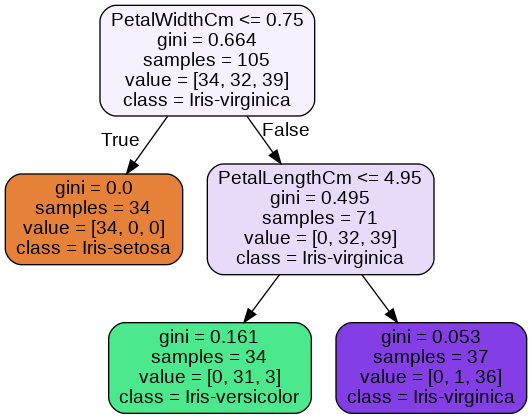

In [553]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
feature_names = train_x.columns
class_names = train_y.unique()
class_names.sort()
export_graphviz(dtc, out_file=dot_data, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Decision trees are easy to inteprete and is often referred to as *whitebox* machine learning algorithm. Let's see how this decision tree represented above makes predictions. Suppose you find an iris flower and want to classify it into setosa, versicolor or virginica. You start at the root node (the very top node in the tree). In this node, we check if the flower's patel length is smaller than or equal to 2.35 cm. If it is, we move to the left child and predict setosa to be its class. Otherwise, we move to the right child node. Then similarly we check if the petal length is smaller than or equal to 4.95 cm. If it is, we move to its left child node and predict versicolor to be its class. Otherwise, we move to its right child and predict virginica to be its class. 

#### Prediction with Decision tree

With this simple decision tree above, we can apply it to make predictions on the test dataset and evaluate its performance.

<span style="color:orange">**Question 3: make prediction using the trained decision tree model on the test data.**

In [554]:
# TODO: use the trained decision tree model to make predictions on the test data and evaluate the model performance.
test_z = dtc.predict(test_x)

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model confusion matrix:\n {}".format(confusion_matrix(test_y, test_z, labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])))


model accuracy: 0.9111111111111111
model confusion matrix:
 [[16  0  0]
 [ 0 17  1]
 [ 0  3  8]]


#### Hyper-parameters

Hyper-parameter controls the complexity of the decision tree model. For example, the deeper the tree is, the more complex patterns the model will be able to capture. In this exercise, we train the decision trees with increasing number of maximum depth and plot its performance. We should see the accuracy of the training data increase as the tree grows deeper, but the accuracy on the test data might not as the model will eventually start to overfit and does not generalize well on the unseen test data.

<span style="color:orange">**Question 4: for each value of max_depth, we train a decision tree model and evaluate its accuracy on both train and test data, and plot both accuracies in the figure.**

In [0]:
# TODO: train the decision tree model with various max_depth, make predictions and evaluate on both train and test data.

#Defining lists
dtc_train_score = []
dtc_test_score = []
dtc_train_error = []
dtc_test_error = []

for i in range(1,7):
  dtc = DecisionTreeClassifier(max_depth=i)
  dtc.fit(train_x,train_y)
  train_score=dtc.score(train_x,train_y)
  train_error = 1-train_score
  test_z=dtc.predict(test_x)
  test_score=accuracy_score(test_y,test_z)
  test_error = 1- test_score
#Appending scores & errors in the lists
  dtc_train_score.append(train_score)
  dtc_test_score.append(test_score)
  dtc_train_error.append(train_error)
  dtc_test_error.append(test_error)

In [556]:
print(dtc_train_score)
print(dtc_test_score)
print(dtc_train_error)
print(dtc_test_error)

[0.6952380952380952, 0.9619047619047619, 0.9809523809523809, 1.0, 1.0, 1.0]
[0.6, 0.9111111111111111, 0.9777777777777777, 0.9777777777777777, 0.9777777777777777, 0.9777777777777777]
[0.3047619047619048, 0.03809523809523807, 0.01904761904761909, 0.0, 0.0, 0.0]
[0.4, 0.0888888888888889, 0.022222222222222254, 0.022222222222222254, 0.022222222222222254, 0.022222222222222254]


In [0]:
dtc_result = {'Depth':[1,2,3,4,5,6],
              'Train_Error':dtc_train_error,
              'Test_Error':dtc_test_error}

In [558]:
dtc_data = pd.DataFrame(dtc_result)
print(dtc_data)

   Depth  Train_Error  Test_Error
0      1     0.304762    0.400000
1      2     0.038095    0.088889
2      3     0.019048    0.022222
3      4     0.000000    0.022222
4      5     0.000000    0.022222
5      6     0.000000    0.022222


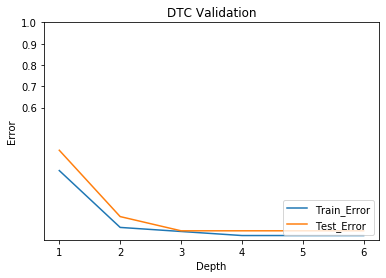

In [559]:
#Plotting depth vs error as stated in Canvas
plt.plot(dtc_data.Depth, dtc_data.Train_Error, label='Train_Error')
plt.plot(dtc_data.Depth, dtc_data.Test_Error, label='Test_Error')
plt.xlabel("Depth") # Text for X-Axis
plt.ylabel("Error") # Text for Y-Axis
plt.title("DTC Validation")
plt.yticks([.6,.7,.8,.9,1])
plt.legend(loc='lower right')
plt.show()

#### Fine-tune the decision tree classifier

Decision tree is a very powerful model with very few assumptions about the incoming training data (unlike linear models, which assume the data linear), however, it is more likely to overfit the data and won't generalize well to unseen data. To void overfitting, we need to restrict the decision tree's freedom during training via regularization (e.g. max_depth, min_sample_split, max_leaf_nodes and etc.).

To fine-tune the model and combat overfitting, use grid search with cross-validation (with the help of the GridSearchCV class) to find the best hyper-parameter settings for the DecisionTreeClassifier. In particular, we would like to fine-tune the following hyper-parameters:
- **criteria**: this defines how we measure the quality of a split. we can choose either "gini" for the Gini impurity or "entropy" for the information gain.
- **max_depth**: the maximum depth of the tree. This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. But meanwhile, deeper trees are more likely to overfit the data. For this practice, we will choose from {1, 2, 3} given there are only 4 features in the iris dataset.
- **min_samples_split**: This value represents the minimum number of samples required to split an internal node. The smaller this value is, the deeper the tree will grow, thus more likely to overfit. On the other hand, if the value is really large (the size of the training data in the extreme case), the tree will be very shallow and could suffer from underfit. In this practice, we choose from {0.01, 0.05, 0.1, 0.2}.

<span style="color:orange">**Question 5: Use grid search with 3-fold cross-validation to fine-tune the decision tree model and output the best hyper-parameters.**

In [560]:
# TODO: fine-tune the model, use grid search with 3-fold cross-validation.
parameters = {
    'max_depth': [1,2,3],
    'min_samples_split': [0.01, 0.05, 0.1, 0.2],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()
grid = GridSearchCV(dt, parameters, cv=3)
grid.fit(train_x,train_y)

# summarize the results of the grid search
print("The best score is {}".format(grid.best_score_))
print("The best hyper parameter setting is {}".format(grid.best_params_))

The best score is 0.9619047619047619
The best hyper parameter setting is {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 0.01}


#### Prediction and Evaluation

Now we have a fine-tuned decision tree classifier based on the training data, let's apply this model to make predictions on the test data and evaluate its performance.

In [561]:
grid.predict(test_x)

print("model accuracy: {}".format(accuracy_score(test_y, test_z)))
print("model confusion matrix:\n {}".format(confusion_matrix(test_y, test_z, labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])))

model accuracy: 0.9777777777777777
model confusion matrix:
 [[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]


### Random Forest

**Question 6: Apply Random Forest together with Gridsearch to the Iris dataset and evaluate its accuracy.**

In [562]:
parameters = {
    "n_estimators": [20,40],
    "max_depth": [3], 
    "min_samples_split": [0.01, 0.05, 0.1, 0.2]
}

rfc_grid = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=0), parameters, cv=3)
rfc_grid.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(rfc_grid.best_score_))
print("The best hyper parameter setting is {}".format(rfc_grid.best_params_))

The best score is 0.9619047619047619
The best hyper parameter setting is {'max_depth': 3, 'min_samples_split': 0.01, 'n_estimators': 40}


In [563]:
test_z = rfc_grid.predict(test_x)
print("model accuracy for RandomForest: {}".format(accuracy_score(test_y, test_z)))

model accuracy for RandomForest: 0.9777777777777777


### Adaboost

**Question 7: Apply Adaboost together with Gridsearch to the Iris dataset and evaluate its accuracy.**

In [564]:
### TODO 
parameters = {
    "n_estimators": [20,40],
    "learning_rate": [0.01, 0.1,1]
}

adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),random_state=0)
adaboost_grid = GridSearchCV(adaboost, parameters, cv=3)
adaboost_grid.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(adaboost_grid.best_score_))
print("The best hyper parameter setting is {}".format(adaboost_grid.best_params_))

The best score is 0.9619047619047619
The best hyper parameter setting is {'learning_rate': 0.1, 'n_estimators': 20}


In [565]:
test_z = adaboost_grid.predict(test_x)
print("model accuracy for Adaboost: {}".format(accuracy_score(test_y, test_z)))

model accuracy for Adaboost: 0.9777777777777777


### Gradient Boosting

**Question 8: Apply Boosting together with Gridsearch to the Iris dataset and evaluate its accuracy.**

In [566]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.1],
    "min_samples_split": [0.05, 0.1, 0.2],
    "max_depth":[1,2,3],
    "n_estimators":[20,40]
}

gbc_grid = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1)
gbc_grid.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(gbc_grid.best_score_))
print("The best hyper parameter setting is {}".format(gbc_grid.best_params_))

The best score is 0.9714285714285715
The best hyper parameter setting is {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'min_samples_split': 0.2, 'n_estimators': 20}


In [567]:
test_z = gbc_grid.predict(test_x)
print("model accuracy for GradientBoost: {}".format(accuracy_score(test_y, test_z)))

model accuracy for GradientBoost: 0.9777777777777777


**BONUS POINT: we will apply the supervised learning models we learnt so far to predict the California housing prices.**

## California Housing Dataset

The California Housing dataset appeared in a 1997 paper titled Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). 

In [0]:
# Load train and test data from CSV files.
train = pd.read_csv('https://raw.githubusercontent.com/zariable/data/master/housing_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/zariable/data/master/housing_test.csv')

train_x = train.iloc[:,0:8]
train_y = train.iloc[:,8]

test_x = test.iloc[:,0:8]
test_y = test.iloc[:,8]

In [613]:
# print the number of instances in each class
print(train_y.value_counts().sort_index())
print(test_y.value_counts().sort_index())

14999.0       3
17500.0       1
22500.0       3
25000.0       1
26600.0       1
           ... 
498700.0      1
499000.0      1
499100.0      1
500000.0     18
500001.0    678
Name: median_house_value, Length: 3548, dtype: int64
14999.0       1
22500.0       1
27500.0       1
28300.0       1
30000.0       1
           ... 
497600.0      1
498400.0      1
498800.0      1
500000.0      9
500001.0    287
Name: median_house_value, Length: 2631, dtype: int64


# Random Forest

In [606]:
#Random Forest
parameters = {
    "max_depth":[2,4,6,7],
    "n_estimators": [20,40]
}

rfc_grid = GridSearchCV(RandomForestRegressor(random_state=42), parameters, cv=3)
rfc_grid.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(rfc_grid.best_score_))
print("The best hyper parameter setting is {}".format(rfc_grid.best_params_))

The best score is 0.7098229390462826
The best hyper parameter setting is {'max_depth': 7, 'n_estimators': 40}


In [607]:
test_z = rfc_grid.predict(test_x)
print("model accuracy for RandomForestRegressor: {}".format(r2_score(test_y, test_z)))

model accuracy for RandomForestRegressor: 0.6938671274086028


# AdaBoost

In [610]:
#AdaBoost
parameters = {
    "n_estimators": [20,40],
    "learning_rate": [0.01, 0.1,1]
}

adaboost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=7),random_state=42)
adaboost_grid = GridSearchCV(adaboost, parameters, cv=3)
adaboost_grid.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(adaboost_grid.best_score_))
print("The best hyper parameter setting is {}".format(adaboost_grid.best_params_))

The best score is 0.7230176388467041
The best hyper parameter setting is {'learning_rate': 0.1, 'n_estimators': 40}


In [611]:
test_z = adaboost_grid.predict(test_x)
print("model accuracy for AdaBoostRegressor: {}".format(r2_score(test_y, test_z)))

model accuracy for AdaBoostRegressor: 0.7107900823589499


# Gradient Boosting

In [614]:
#Gradient Boosting
parameters = {
    "learning_rate": [0.01, 0.1, 1],
    "max_depth":[2,4,6,7],
    "n_estimators":[20,40]
}

gbc_grid = GridSearchCV(GradientBoostingRegressor(), parameters, cv=3, n_jobs=-1)
gbc_grid.fit(train_x, train_y)

# summarize the results of the grid search
print("The best score is {}".format(gbc_grid.best_score_))
print("The best hyper parameter setting is {}".format(gbc_grid.best_params_))

The best score is 0.7968214913227988
The best hyper parameter setting is {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 40}


In [615]:
test_z = gbc_grid.predict(test_x)
print("model accuracy for GradientBootRegressor: {}".format(r2_score(test_y, test_z)))

model accuracy for GradientBootRegressor: 0.8011874000021633


### End of Assignment 2
---
